In [25]:
!pip install --upgrade pip
!pip3 install numpy pandas matplotlib scikit-learn tensorflow transformers torch Pillow requests pyngrok streamlit deep_translator googletrans==4.0.0-rc1

In [26]:
import numpy as np
import pandas as pd
import os
import re
import pickle
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, concatenate, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import VGG16, DenseNet201
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import random


In [27]:
data_path = "C:\\Users\\Lenovo\\OneDrive - Egyptian E-Learning University\\Documents\\shahd\\captions.txt"
image_dir =  "C:\\Users\\Lenovo\\OneDrive - Egyptian E-Learning University\\Documents\\shahd\\Images"
features_path =  "C:\\Users\\Lenovo\\OneDrive - Egyptian E-Learning University\\Documents\\shahd\\features.pkl"
tokenizer_path =  "C:\\Users\\Lenovo\\OneDrive - Egyptian E-Learning University\\Documents\\shahd\\tokenizer.pkl"
model_weights_dir =  "C:\\Users\\Lenovo\\OneDrive - Egyptian E-Learning University\\Documents\\shahd\\ImageCaptioningModels"
os.makedirs(model_weights_dir, exist_ok=True)
print(f" Paths: \n{data_path}\n{image_dir}\n{features_path}\n{tokenizer_path}\n{model_weights_dir}")

 Paths: 
C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\captions.txt
C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\Images
C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\features.pkl
C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\tokenizer.pkl
C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\ImageCaptioningModels


C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


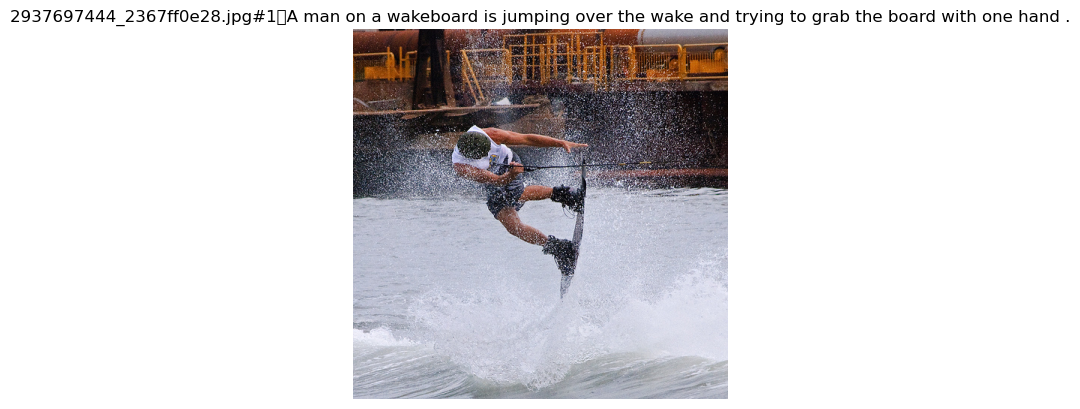

In [28]:
def display_random_image_with_caption(data_path, image_dir):
    with open(data_path, 'r') as file:
        captions = file.readlines()
    
    caption = random.choice(captions).strip()
    image_id = caption.split('#')[0] 
    image_path = os.path.join(image_dir, image_id)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Usage
display_random_image_with_caption(data_path, image_dir)

In [29]:
# 3. Text Cleaning and Tokenizer Preparation
data = pd.read_csv(data_path,  
                 delimiter='\t',
                 header=None,
                 names=['img_files', 'descriptions'])
print(f"Successfully retrieved {len(data)} records")
if 'img_files' not in data.columns or 'descriptions' not in data.columns:
    raise ValueError("Required fields 'img_files' or 'descriptions' not found")
data['image'] = data['img_files'].astype(str).apply(lambda x: x.split('#')[0])  # Clean image name
data['caption'] = data['descriptions'].astype(str)  # Fixed from 'captions' to 'descriptions'
print(f"Sample processed image: {data['image'].iloc[0]}")
print(f"Unique images count: {data['image'].nunique()}")

Successfully retrieved 40455 records
Sample processed image: 1000268201_693b08cb0e.jpg
Unique images count: 8091


In [30]:
def cleandescriptions(text ,add_special_tokens=True, keep_numbers=False):
    text = text.lower()  
    if keep_numbers:
        pattern = r'[^a-z0-9 ]'
    else:
        pattern = r'[^a-z ]'
    text = re.sub(pattern, '', text)
    
    # White space normalization
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Optional sequence tokens
    if add_special_tokens:
        text = 'startseq ' + text + ' endseq'
    
    return text
data['caption_cleaned'] = data['caption'].apply(cleandescriptions)
print("\nText cleaning examples:")
print("Original:", data['caption'].iloc[0])
print("Processed:", data['caption_cleaned'].iloc[0])

if os.path.exists(tokenizer_path):
    print("\nLoading existing tokenizer...")
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print(f"Tokenizer loaded with {len(tokenizer.word_index)} vocabulary items")
else:
    print("\nCreating new tokenizer...")
    tokenizer = Tokenizer(
        num_words=None,  # You can set a limit here (e.g., 5000)
        filters='',  # We already did our own filtering
        oov_token='<unk>'  # Add out-of-vocabulary token
    )
    tokenizer.fit_on_texts(data['caption_cleaned'])
    
    # Save tokenizer
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    print(f"New tokenizer created with {len(tokenizer.word_index)} vocabulary items")
    print("Sample word index:", list(tokenizer.word_index.items())[:5])
vocab_size  = len(tokenizer.word_index) + 1  
lengths = [len(txt.split()) for txt in data['caption_cleaned']]
max_length = max(lengths)
avg_length = sum(lengths)/len(lengths)

print("\nVocabulary statistics:")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Max sequence length: {max_length}")
print(f"- Average sequence length: {avg_length:.1f}")
print(f"- 95th percentile length: {sorted(lengths)[int(len(lengths)*0.95)]}")


Text cleaning examples:
Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Processed: startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq

Loading existing tokenizer...
Tokenizer loaded with 8767 vocabulary items

Vocabulary statistics:
- Vocabulary size: 8768
- Max sequence length: 37
- Average sequence length: 12.8
- 95th percentile length: 20


In [31]:
def extract_features():
   
    print(f"Extracting features using {model_type.upper()}...")
    if model_type == 'densenet':
        model = DenseNet201(include_top=False, weights='imagenet', pooling='avg')
        preprocess = tf.keras.applications.densenet.preprocess_input
    else:
        model = VGG16(include_top=False, weights='imagenet', pooling='avg')
        preprocess = tf.keras.applications.vgg16.preprocess_input
    
    features = {}
    missing_images = []
    
    
    for img_name in tqdm(data['image'].unique(), desc="Processing Images"):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            missing_images.append(img_name)
            continue
            
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess(np.expand_dims(img_array, axis=0))
            feature = model.predict(img_array, verbose=0).squeeze()
            features[img_name] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")
    
    return features, missing_images


if os.path.exists(features_path):
    print(" Loading pre-existing features...")
    with open(features_path, 'rb') as f:
        features = pickle.load(f)
    print(f" Loaded {len(features)} features from {features_path}")
else:
    features, missing_images = extract_features()
    print(f"Saving {len(features)} features to {features_path}...")
    with open(features_path, 'wb') as f:
        pickle.dump(features, f)
    
    if missing_images:
        print(f" Could not process {len(missing_images)} images")
example_feature = next(iter(features.values()))
feature_size = example_feature.shape[-1]
if features:
    sample_feature = next(iter(features.values()))
    print("\nFeature Analysis:")
    print(f"Shape: {sample_feature.shape}")
    print(f"Size: {sample_feature.shape[-1]} dimensions")
    print(f"Sample values: {sample_feature[:5]}")
    
    # Statistics
    all_features = np.array(list(features.values()))
    print("\n Statistics:")
    print(f"Min: {np.min(all_features):.4f}")
    print(f"Max: {np.max(all_features):.4f}")
    print(f"Mean: {np.mean(all_features):.4f}")
    print(f"Std Dev: {np.std(all_features):.4f}")
else:
    print("No features were loaded or extracted")


 Loading pre-existing features...
 Loaded 8091 features from C:\Users\Lenovo\OneDrive - Egyptian E-Learning University\Documents\shahd\features.pkl

Feature Analysis:
Shape: (1, 1920)
Size: 1920 dimensions
Sample values: [[7.8687917e-05 7.3524064e-04 1.1395990e-03 ... 5.6523514e-01
  2.2903775e-01 6.9639796e-01]]

 Statistics:
Min: 0.0000
Max: 19.6174
Mean: 0.3019
Std Dev: 0.6359


In [32]:
sequences = tokenizer.texts_to_sequences(data['caption_cleaned'])  
X_seq = pad_sequences(sequences, maxlen=max_length, padding='post')  #  same length 0000


image_to_seq_map = {}
for img_name, seq in zip(data['image'], X_seq):
    if img_name not in image_to_seq_map:
        image_to_seq_map[img_name] = []
    image_to_seq_map[img_name].append(seq)

In [33]:
tf.random.set_seed(42)
np.random.seed(42)
unique_images = data['image'].unique()
img_train_names, img_val_names = train_test_split(unique_images, test_size=0.2) 
print("train images:", len(img_train_names), ", Value images:", len(img_val_names))

train images: 6472 , Value images: 1619


In [34]:
class DataGenerator(Sequence):
    def __init__(self, img_names, image_to_seq_map, features, batch_size, max_length, vocab_size, shuffle=True):
        self.img_names = img_names
        self.image_to_seq_map = image_to_seq_map
        self.features = features
        self.batch_size = batch_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle

        # Validate and prepare data pairs
        self.pairs = self._validate_and_prepare_pairs()
        self.indices = np.arange(len(self.pairs))
        self.on_epoch_end()
        
        # Pre-allocate memory for batch storage
        feature_dim = next(iter(features.values())).shape[-1]
        self.X_img_batch = np.zeros((batch_size, feature_dim))
        self.X_seq_batch = np.zeros((batch_size, max_length))
        self.y_batch = np.zeros((batch_size, vocab_size))

    def _validate_and_prepare_pairs(self):
        pairs = []
        missing_images = 0
        missing_sequences = 0
        
        for img_name in self.img_names:
            if img_name not in self.features:
                missing_images += 1
                continue
                
            if img_name not in self.image_to_seq_map:
                missing_sequences += 1
                continue
                
            sequences = self.image_to_seq_map[img_name]
            for seq in sequences:
                if len(seq) > 1:  # Only include sequences with at least 2 tokens
                    pairs.append((img_name, seq))
        
        if missing_images > 0:
            print(f"Warning: {missing_images} images missing from features")
        if missing_sequences > 0:
            print(f"Warning: {missing_sequences} images missing sequences")
            
        print(f"Created {len(pairs)} valid (image, sequence) pairs")
        return pairs

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_pairs = [self.pairs[i] for i in batch_indices]
        
        batch_size = len(batch_pairs)
        X_img = np.zeros((batch_size, self.X_img_batch.shape[1]))
        X_seq = np.zeros((batch_size, self.max_length))
        y = np.zeros((batch_size, self.vocab_size))
        
        for i, (img_name, seq) in enumerate(batch_pairs):
            img_feature = self.features[img_name].squeeze()
            
            seq_len = min(len(seq), self.max_length + 1)
            if seq_len > 1:
                pos = np.random.randint(1, seq_len) if self.shuffle else 1
                input_seq = pad_sequences([seq[:pos]], maxlen=self.max_length, padding='post')[0]
                output_word = to_categorical([seq[pos]], num_classes=self.vocab_size)[0]
                
                X_img[i] = img_feature
                X_seq[i] = input_seq
                y[i] = output_word
        
        return [X_img, X_seq], y

batch_size = 32
train_gen = DataGenerator(
    img_names=img_train_names,
    image_to_seq_map=image_to_seq_map,
    features=features,
    batch_size=batch_size,
    max_length=max_length,
    vocab_size=vocab_size,
    shuffle=True
)

val_gen = DataGenerator(
    img_names=img_val_names,
    image_to_seq_map=image_to_seq_map,
    features=features,
    batch_size=batch_size,
    max_length=max_length,
    vocab_size=vocab_size,
    shuffle=False
)

# Verify the generator
sample_X, sample_y = train_gen[0]
print("\nBatch shape verification:")
print(f"Image features: {sample_X[0].shape}")
print(f"Input sequences: {sample_X[1].shape}")
print(f"Target words: {sample_y.shape}")

Created 32360 valid (image, sequence) pairs
Created 8095 valid (image, sequence) pairs

Batch shape verification:
Image features: (32, 1920)
Input sequences: (32, 37)
Target words: (32, 8768)


In [35]:
def train_model(model, model_name, train_gen, val_gen, model_weights_dir, epochs=15):
    model_weights_path = os.path.join(model_weights_dir, f"{model_name}_full_model.keras")
    print(f"\nDEBUG: ----- Training/Loading model: {model_name} -----")

    # Check if the model weights already exist
    if os.path.exists(model_weights_path):
        print(f"DEBUG: Found weights file! Loading the model weights...")
        model.load_weights(model_weights_path)
        return model

    # Train the model if weights don't exist
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[
            # Save the best model based on validation loss
            tf.keras.callbacks.ModelCheckpoint(
                model_weights_path, save_best_only=True, save_weights_only=False, monitor='val_loss', verbose=1
            ),
            # Stop training early if the validation loss doesn't improve
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, verbose=1, restore_best_weights=True
            )
        ],
        verbose=1
    )

    print(f"Model training completed: {model_name} -----")
    return history

In [36]:
def build_model2(feature_size, vocab_size, max_length):
    # Image input branch (input shape is the feature size)
    image_input = Input(shape=(feature_size,))
    img_feats = Dense(256, activation='relu')(image_input)  # Dense layer for image features

    # Caption input branch (input shape is the maximum length of the sequence)
    caption_input = Input(shape=(max_length,))
    emb = Embedding(vocab_size, 256, mask_zero=True)(caption_input)  # Embedding layer for words
    lstm = Bidirectional(LSTM(128))(emb)  # Bidirectional LSTM to process the sequence of words

    # Combine image and caption features
    combined = concatenate([img_feats, lstm])

    # Output layer (predict the next word)
    output = Dense(vocab_size, activation='softmax')(combined)

    # Create and compile the model
    model = Model([image_input, caption_input], output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [37]:
# Build the model using a Bidirectional LSTM layer
model2 = build_model2(feature_size, vocab_size, max_length)

# Train the model for 15 epochs
# `train_model` function will handle the training process and saving the model weights
train_model(model2, "model2_bilstm", train_gen, val_gen, model_weights_dir, epochs=15)


DEBUG: ----- Training/Loading model: model2_bilstm -----
DEBUG: Found weights file! Loading the model weights...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Functional name=functional_2, built=True>